In [1]:
%config IPCompleter.greedy=True  # Podpowiedzi składni
import numpy as np
from scipy.spatial import distance_matrix
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import random
import itertools
import math
import copy
import time
from sortedcontainers import SortedList

# Własna funkcja zaokrąglająca
def round2(number):
    if (number - math.trunc(number) >= 0.5):
        return math.trunc(number) + 1
    else:
        return math.trunc(number)

In [2]:
file = open('kroA200.tsp.txt')
#file = open('kroB200.tsp.txt')

In [3]:
# Pomiń zbędne linie

next_line = file.readline()[0:-1]
while next_line[0] != "1":
    next_line = file.readline()[0:-1]
print(next_line)

1 1357 1905


In [4]:
# Wczytaj wszystkie punkty do tablicy

points_tab = []
while next_line!= "EOF":
    points_tab.append(next_line.split(" "))
    next_line = file.readline()[0:-1]
    
for x in range(len(points_tab)):
    for y in range(len(points_tab[0])):
        points_tab[x][y] = int(points_tab[x][y])
    points_tab[x][0] = points_tab[x][0] - 1  # zmniejsz identyfikatory punktów o 1
print(len(points_tab))
print(len(points_tab[0]))


#print(points_tab)

200
3


In [5]:
# Utwórz tablicę odległości między punktami

length_tab = list(np.zeros((len(points_tab),len(points_tab)), dtype=int))
for x in range(len(length_tab)):
    for y in range(len(length_tab[0])):
        length_tab[x][y] = round2(math.sqrt((points_tab[x][1] - points_tab[y][1])**2 + (points_tab[x][2] - points_tab[y][2])**2))  # długość między punktem "x" i "y" w tablicy base_tab

        
#print(length_tab)

In [6]:
# Funkcja zwracająca długość ścieżki

def distance(path):
    dist = 0
    for x in range(len(path) - 1):
        dist+=length_tab[path[x]][path[x+1]]
    dist+=length_tab[path[len(path)-1]][path[0]]
    return dist

In [7]:
# funkcja zwracająca losową ścieżkę

def get_random_path(data_size = 200):
    path = np.arange(data_size)
    np.random.shuffle(path)
    inside = list(path[:int(data_size/2)])
    outside = list(path[int(data_size/2):])
    return inside, outside

In [8]:
# Funkcja rysująca punkty na płaszczyźnie - zależnie od pochodzenia odpowiednio w różnych kolorach, połączone lub nie

def print_graph(path, out):
    points_inside = []
    points_outside = []

    plt.figure()
    for i in path:
        points_inside.append(copy.deepcopy(points_tab[i][1:]))
    for i in out:
        points_outside.append(copy.deepcopy(points_tab[i][1:]))

    points_inside_0 = []
    for x in points_inside:
        points_inside_0.append(copy.deepcopy(x[0]))
    points_inside_0.append(copy.deepcopy(points_inside[0][0]))
    
    points_inside_1 = []
    for x in points_inside:
        points_inside_1.append(copy.deepcopy(x[1]))
    points_inside_1.append(copy.deepcopy(points_inside[0][1]))

    points_outside_0 = []
    for x in points_outside:
        points_outside_0.append(copy.deepcopy(x[0]))
    points_outside_1 = []
    for x in points_outside:
        points_outside_1.append(copy.deepcopy(x[1]))

    plt.plot(points_inside_0,points_inside_1, '-o')
    plt.plot(points_outside_0,points_outside_1, 'o')
    plt.show()

    
#print_graph(path, out)

In [9]:
# Funkcje pomocnicze

def p_dist(a, b):  
    return length_tab[a][b]

def out_of(a, size = 100):  
    if a < 0:
        a = size + a
    if a >= size:
        a = a - size
    return a

In [10]:
# Funkcje algorytmu steepest

def give_good_edges(path):
    best_imp1 = 0
    best_edges = []
    
    rx = random.randint(0, len(path)-1)  # Element losowości
    ry = random.randint(0, len(path)-1)
    

    for x in range(len(path))[:]:  # Dla każdej krawędzi
        for y in range(len(path))[:]:  # Dla każdej innej krawędzi
            if out_of(x + rx) != out_of(y + ry):

                new_imp = p_dist(path[out_of(x + rx)], path[out_of(x+1 + rx)]) + p_dist(path[out_of(y + ry)], path[out_of(y+1 + ry)]) - p_dist(path[out_of(x + rx)], path[out_of(y + ry)]) - p_dist(path[out_of(x+1 + rx)], path[out_of(y+1 + ry)])
                
                if new_imp > best_imp1:  # Jeśli jest to dobre rozwiązanie, od razu je zwróć
                    return new_imp, [out_of(x + rx), out_of(y + ry)]
   
    return best_imp1, best_edges


def give_good_vertices(path, out):
    best_imp2 = 0
    best_vertices = []
    
    rx = random.randint(0, len(path)-1)  # Element losowości
    ry = random.randint(0, len(path)-1)
    
    for x in range(len(path))[:]:  # Dla każdego wierzchołka ze ścieżki
        for y in range(len(out))[:]:  # Dla każdego wierzchołka spoza ścieżki

            new_imp = p_dist(path[out_of(x-1 + rx)], path[out_of(x + rx)]) + p_dist(path[out_of(x + rx)], path[out_of(x+1 + rx)]) - p_dist(path[out_of(x-1 + rx)], out[out_of(y + ry)]) - p_dist(out[out_of(y + ry)], path[out_of(x+1 + rx)])
            
            if new_imp > best_imp2:  # Jeśli jest to dobre rozwiązanie, od razu je zwróć
                return new_imp, [out_of(x + rx), out_of(y + ry)]
                    
    return best_imp2, best_vertices


In [11]:
# Funkcja zmieniająca ścieżkę zgodnie z podanymi danymi

def change_your_path(path, out, best_imp1, best_imp2, best_edges, best_vertices):
    
    if best_imp1 >= best_imp2:  #podmień krawędzie
        
        x = best_edges[0]
        y = best_edges[1]

        for z in range(int(abs(y - x)/2)):  # Zamiana krawędzi, czyli obrócenie kolejności (krawędź1; krawędź2>
            if x < y:
                path[x + 1 + z], path[y - z] = path[y - z], path[x + 1 + z]
            else:
                path[y + 1 + z], path[x - z] = path[x - z], path[y + 1 + z]
                
    else:  #podmień punkty
        
        x = path[best_vertices[0]]
        y = out[best_vertices[1]]

        path.insert(path.index(x), y)
        path.remove(x)

        out.append(x)
        out.remove(y)

# Zbieranie ścieżek dla zbioru

In [12]:
repeat_test = 1000

Min_path: 14736
Average_path: 16997.493
Max_path: 20313

Min_time: 0.969783600000028
Avg_time: 2.289786347600001
Max_time: 4.6958981000002495

BEST: 14736


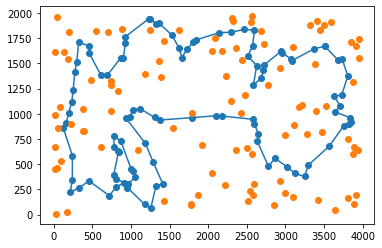

In [13]:
min_path = 1000000
avg_path = 0
max_path = 0

min_time = time.perf_counter() + 100000
avg_time = 0
max_time = 0

best_path = [0]
best_out = [0]



path_list = []

for alfa in range(repeat_test):
    path_time = time.perf_counter()
    

    # ALGORYTM ZACHŁANNY / GREEDY
    path, out = get_random_path(len(points_tab))
    
    while(True):
        
        best_imp1, best_edges = give_good_edges(path)
        best_imp2, best_vertices = give_good_vertices(path, out)

        # Jeśli znaleziono poprawę: zapisz rezultat
        if best_imp1 > 0 or best_imp2 > 0:  
            change_your_path(path, out, best_imp1, best_imp2, best_edges, best_vertices)    
        # Jeśli nie: zakończ
        else:
            break
    
    path_time = time.perf_counter() - path_time
    
    
    # Obliczanie statystyk
    if distance(path) < min_path:
        min_path = distance(path)
        best_path = path
        best_out = out
    if distance(path) > max_path:
        max_path = distance(path)
    avg_path += distance(path)
        
    if path_time < min_time:
        min_time = path_time
    if path_time > max_time:
        max_time = path_time
    avg_time += path_time
    

    path_list.append([path, out])
    
    
    
print("Min_path: "+str(min_path))
avg_path = avg_path/(repeat_test)
print("Average_path: "+str(avg_path))
print("Max_path: "+str(max_path))
print()
print("Min_time: "+str(min_time))
avg_time /= repeat_test
print("Avg_time: "+str(avg_time))
print("Max_time: "+str(max_time))


print("\nBEST: ", end = '')
print(distance(best_path))
print_graph(best_path, best_out)
    



In [14]:
############ DO NOT USE - SAFETY PURPOSE
safe_list_A = copy.deepcopy(path_list)
############ DO NOT USE - SAFETY PURPOSE

In [15]:
# PATH_LIST
print(len(path_list))
#for beta in range(len(path_list)):
    #print(distance(path_list[beta][0]))

1000


# Podobieństwo

In [16]:
# best_path wciąż w pamięci

print(best_path)

[102, 113, 97, 87, 27, 38, 37, 70, 55, 151, 177, 195, 85, 94, 93, 90, 149, 172, 22, 34, 1, 180, 124, 76, 157, 127, 100, 3, 162, 92, 105, 148, 191, 107, 68, 141, 130, 179, 155, 99, 73, 56, 35, 98, 18, 91, 9, 174, 196, 44, 32, 80, 96, 103, 164, 95, 165, 47, 115, 187, 62, 15, 117, 123, 137, 25, 135, 60, 183, 28, 171, 45, 120, 173, 116, 114, 52, 0, 84, 190, 26, 197, 122, 14, 159, 161, 54, 185, 119, 46, 156, 186, 5, 108, 106, 154, 182, 21, 133, 145]


In [17]:
results = []

for gamma in range(len(path_list)):
    
    # Podobieństwo ścieżek do najlepszej ścieżki
    comm_vertices_best = 0
    comm_edges_best = 0
    
    for x in range(len(best_path)):
        if best_path[x] in path_list[gamma][0]:
            comm_vertices_best += 1  # Wspólny wierzchołek
        for y in range(len(path_list[gamma][0])):
            if best_path[x] == path_list[gamma][0][y]:
                if best_path[out_of(x+1)] == path_list[gamma][0][out_of(y - 1)] or best_path[out_of(x+1)] == path_list[gamma][0][out_of(y + 1)]:
                    comm_edges_best += 1  # Wspólna krawędź
    
    
    
    # Średnie podobieństwo ścieżek do pozostałych ścieżek
    comm_vertices_mean = 0
    comm_edges_mean = 0
    
    for z in range(len(path_list)):
        if gamma != z:  # Nie bierzemy pod uwagę tej samej ścieżki
            for x in range(len(path_list[gamma][0])):
                if path_list[gamma][0][x] in path_list[z][0]:
                    comm_vertices_mean += 1  # Wspólny wierzchołek
                for y in range(len(path_list[z][0])):
                    if path_list[gamma][0][x] == path_list[z][0][y]:
                        if path_list[gamma][0][out_of(x+1)] == path_list[z][0][out_of(y - 1)] or path_list[gamma][0][out_of(x+1)] == path_list[z][0][out_of(y + 1)]:
                            comm_edges_mean += 1  # Wspólna krawędź
    
    # Końcowe poprawki dla podobieństw ścieżek do pozostałych ścieżek
    comm_vertices_mean /= (len(path_list) - 1)  # -1 -> Nie bierzemy pod uwagę tej samej ścieżki
    comm_edges_mean /= (len(path_list) - 1)
    
    
    
    results.append([comm_vertices_best, comm_edges_best, comm_vertices_mean, comm_edges_mean])
    
#print(results)

# Wykresy i korelacje

In [18]:
def print_graph_2(dist, comm):
    plt.plot(dist, comm, 'o')
    plt.xlabel("Długość ścieżki", fontsize = 15)
    plt.ylabel("Podobieństwo", fontsize = 15)
    plt.show()

Ilość wspólnych wierzchołków z najlepszą ścieżką:
Współczynnik korelacji: (-0.342226222081278, 7.412653317753169e-29)


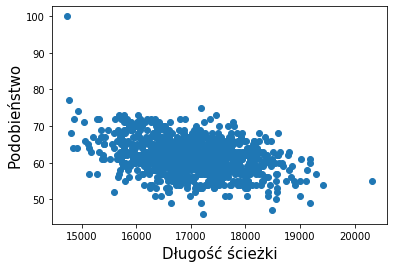



Ilość wspólnych krawędzi z najlepszą ścieżką:
Współczynnik korelacji: (-0.3939537624630444, 1.7980335332146765e-38)


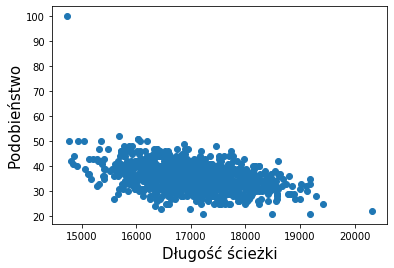



Średnia ilość wspólnych wierzchołków z innymi ścieżkami:
Współczynnik korelacji: (-0.41077373875005535, 5.451810371811972e-42)


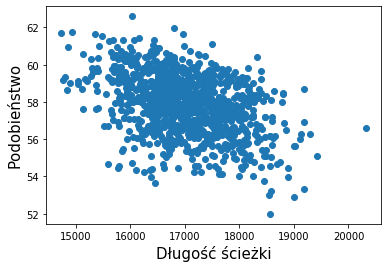



Średnia ilość wspólnych krawędzi z innymi ścieżkami:
Współczynnik korelacji: (-0.6629161951035035, 1.367011293656658e-127)


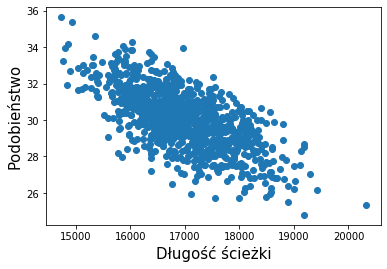

In [19]:
distances = []
for x in range(len(path_list)):
    distances.append(distance(path_list[x][0]))



print("Ilość wspólnych wierzchołków z najlepszą ścieżką:")
print("Współczynnik korelacji: ", end = '')

commons = []
for x in range(len(path_list)):
    commons.append(results[x][0])

print(pearsonr(distances, commons))
print_graph_2(distances,commons)



print("\n\nIlość wspólnych krawędzi z najlepszą ścieżką:")
print("Współczynnik korelacji: ", end = '')

commons = []
for x in range(len(path_list)):
    commons.append(results[x][1])

print(pearsonr(distances, commons))
print_graph_2(distances,commons)



print("\n\nŚrednia ilość wspólnych wierzchołków z innymi ścieżkami:")
print("Współczynnik korelacji: ", end = '')

commons = []
for x in range(len(path_list)):
    commons.append(results[x][2])

print(pearsonr(distances, commons))
print_graph_2(distances,commons)



print("\n\nŚrednia ilość wspólnych krawędzi z innymi ścieżkami:")
print("Współczynnik korelacji: ", end = '')

commons = []
for x in range(len(path_list)):
    commons.append(results[x][3])

print(pearsonr(distances, commons))
print_graph_2(distances,commons)

In [20]:
print("DONE")

DONE
